In [11]:
# Import all required packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
from scipy.stats import randint,uniform
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, PrecisionRecallDisplay, average_precision_score,precision_recall_curve,auc
import seaborn as sn
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree  import DecisionTreeClassifier
import warnings

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures,StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import pipeline,set_config
from sklearn.utils import class_weight
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, PrecisionRecallDisplay, precision_score, \
    average_precision_score, auc, precision_recall_curve, make_scorer,SCORERS
from skopt import BayesSearchCV
import datetime, re, sys, holidays
import CommonFunctions
from Functions import *
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm  import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from importlib import reload

set_config(display="diagram")
np.random.seed (0)
Parallel(n_jobs=8, max_nbytes=50000)

warnings.filterwarnings("ignore")

In [2]:
categorical_cols = ['Vessel Type']
vessel_cols = ['Total Vessels (Number)', 'Capesize',
                'Capesize Laden', 'Capesize Unladen', 'Panamax', 'Panamax Laden',
                'Panamax Unladen', 'Handymax', 'Handymax Laden', 'Handymax Unladen',
                'Handysize', 'Handysize Laden', 'Handysize Unladen']
# date_cols = ['Berth or Port Entry', 'Date']
date_cols = ['Date']
dwt_cols = ['Total Vessels (DWT)','Capesize (DWT)',
            'Capesize Laden (DWT)', 'Capesize Unladen (DWT)', 'Panamax (DWT)',
            'Panamax Laden (DWT)', 'Panamax Unladen (DWT)', 'Handymax (DWT)',
            'Handymax Laden (DWT)', 'Handymax Unladen (DWT)', 'Handysize (DWT)',
            'Handysize Laden (DWT)', 'Handysize Unladen (DWT)']
weather_cols = ['tempt', 'prcp', 'wspd']

predict_col_src = 'Waiting Time (Days)'
predict_col = 'Wait Levels'

In [3]:
# Get data
data = pd.read_csv('clean_data.csv', index_col=0, parse_dates=date_cols)
weather_df = pd.read_csv('sao_paulo_weather.csv', parse_dates=['date'])
weather_df = weather_df[['date','tavg','prcp','wspd']].rename(columns={'date': 'Date',
                   'tavg': 'tempt',
                   'prcp': 'prcp',
                   'wspd': 'wspd'}, inplace=False)
weather_df = weather_df.fillna(0)
data = data.merge(weather_df, how='inner',left_on=['Date'], right_on=['Date'])

# Drop cols with only 1 value
for col in data.columns:
    if len(data[col].unique()) == 1:
        data.drop(col,axis=1, inplace=True)

data.drop('Berth or Port Entry',axis=1, inplace=True)

#convert DWT cols from obj to int
for col in dwt_cols:
    data[col] = data[col].str.replace(",","").astype(int)
#convert vessel_cols from float to int
for col in vessel_cols:
    data[col] = data[col].astype(int)

def predictDays(x):
    if x >= 10:
        return 3
    elif x >= 7:
        return 2
    elif x >= 4:
        return 1
    else:
        return 0
data[predict_col] = data[predict_col_src].apply(lambda x : predictDays(x))

# split to train & Test
X_train, X_test, y_train, y_test = train_test_split(data.drop(predict_col,axis=1, inplace=False), data[predict_col], test_size=0.8, random_state=0,stratify=data[predict_col])

#print cleaned data
data

,IMO,Waiting Time (Days),Vessel Type,Date,Total Vessels (Number),Total Vessels (DWT),Capesize,Capesize Laden,Capesize Unladen,Panamax,...,Handymax (DWT),Handymax Laden (DWT),Handymax Unladen (DWT),Handysize (DWT),Handysize Laden (DWT),Handysize Unladen (DWT),Wait Levels,tempt,prcp,wspd
0,9056399,0.2,3,2015-01-02,16,878272,0,0,0,5,...,432704,121785,310919,52823,30060,22763,0,27.0,0.0,15.1
1,9471252,3.4,2,2015-01-02,16,878272,0,0,0,5,...,432704,121785,310919,52823,30060,22763,0,27.0,0.0,15.1
2,9233399,5.6,3,2015-01-02,16,878272,0,0,0,5,...,432704,121785,310919,52823,30060,22763,1,27.0,0.0,15.1
3,8309141,0.5,1,2015-01-03,17,908718,0,0,0,5,...,474533,107174,367359,70297,36036,34261,0,23.3,3.0,13.8
4,9625970,3.9,2,2015-01-03,17,908718,0,0,0,5,...,474533,107174,367359,70297,36036,34261,0,23.3,3.0,13.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9942,9669392,10.3,3,2021-12-19,47,2880415,0,0,0,22,...,672159,433059,239100,449635,415650,33985,3,17.6,0.0,17.3
9943,9911678,1.9,3,2021-12-28,49,2910427,0,0,0,20,...,870577,552785,317792,465851,308646,157205,0,21.6,0.0,9.8
9944,9476927,2.9,3,2021-12-28,49,2910427,0,0,0,20,...,870577,552785,317792,465851,308646,157205,0,21.6,0.0,9.8
9945,9305219,0.6,2,2021-12-30,47,2744630,0,0,0,17,...,929509,488312,441197,458868,341163,117705,0,20.3,0.0,10.6


In [50]:
date_linear_processor = pipeline.Pipeline([('ProcessDates',ProcessDates()),('ProcessHolidays',ProcessHolidays()),('DropDate',DropCol(cols=date_cols))])
numeric_linear_processor = pipeline.Pipeline([('Polynomial',PolynomialFeatures(degree=2,interaction_only =True,include_bias=True)),('Scaler',StandardScaler())])
cat_linear_processor = OneHotEncoder()
vessel_linear_processor = pipeline.Pipeline([('CreateDummyCol',CreateDummyCol()),('ProcessVessel',ProcessVessel(vessel_cols=vessel_cols,dwt_cols=dwt_cols))])
weather_linear_processor = pipeline.Pipeline([('CreateDummyCol',CreateDummyCol()),('ProcessWeather',ProcessWeather()),('ProcessWSpd',ProcessWSpd())])

data_preprocessor = ColumnTransformer([
    # ('numeric_linear_processor',numeric_linear_processor, numeric_cols),
    ('cat_linear_processor',cat_linear_processor, categorical_cols),
    ('date_linear_processor',date_linear_processor, date_cols),
    ('vessel_linear_processor',vessel_linear_processor, vessel_cols+dwt_cols),
    ('weather_linear_processor',weather_linear_processor, weather_cols)
])
data_preprocessor


ColumnTransformer(transformers=[('cat_linear_processor', OneHotEncoder(),
                                 ['Vessel Type']),
                                ('date_linear_processor',
                                 Pipeline(steps=[('ProcessDates',
                                                  ProcessDates()),
                                                 ('ProcessHolidays',
                                                  ProcessHolidays()),
                                                 ('DropDate',
                                                  DropCol(cols=['Date']))]),
                                 ['Date']),
                                ('vessel_linear_processor',
                                 Pipeline(steps=[('CreateDummyCol',
                                                  CreateDummyCol()),
                                                 ('ProcessVessel',
                                                  Process...
                                  'Capesize Unladen (DWT)', 'Panamax (DWT)',
                                  'Panamax Laden (DWT)',
                                  'Panamax Unladen (DWT)', 'Handymax (DWT)',
                                  'Handymax Laden (DWT)',
                                  'Handymax Unladen (DWT)', 'Handysize (DWT)',
                                  'Handysize Laden (DWT)',
                                  'Handysize Unladen (DWT)']),
                                ('weather_linear_processor',
                                 Pipeline(steps=[('CreateDummyCol',
                                                  CreateDummyCol()),
                                                 ('ProcessWeather',
                                                  ProcessWeather()),
                                                 ('ProcessWSpd',
                                                  ProcessWSpd())]),
                                 ['tempt', 'prcp', 'wspd'])])

In [51]:
estimators = [
    ("LightGBM", LGBMClassifier(objective='multiclass',random_state=0,n_jobs=-1,device = 'gpu',class_weight='balanced')),
    ("XGBoost", XGBClassifier(objective='multi:softmax',random_state=0,n_jobs=-1,use_label_encoder=False,  tree_method = 'gpu_hist',eval_metric='mlogloss')),
    ("RandomForest", RandomForestClassifier(random_state=0)),
    ("DecisionTree", DecisionTreeClassifier()),
]
final_estimator=LGBMClassifier(objective='multiclass',random_state=0,n_jobs=-1,device = 'gpu')
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=final_estimator,stack_method='predict_proba',n_jobs=-1)
finalPipe = pipeline.make_pipeline(data_preprocessor,DropZeroCol(),stacking_classifier)

finalestimators = []
for estimator, model in estimators:
    finalestimators.append((estimator,pipeline.Pipeline([('columntransformer',data_preprocessor),('DropZeroCol',DropZeroCol()),(estimator,model)])))

finalPipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_linear_processor',
                                                  OneHotEncoder(),
                                                  ['Vessel Type']),
                                                 ('date_linear_processor',
                                                  Pipeline(steps=[('ProcessDates',
                                                                   ProcessDates()),
                                                                  ('ProcessHolidays',
                                                                   ProcessHolidays()),
                                                                  ('DropDate',
                                                                   DropCol(cols=['Date']))]),
                                                  ['Date']),
                                                 ('vessel_linear_processor',
                                                  Pipeline(steps=[('CreateDummyCol',
                                                                   Creat...
                                                               reg_lambda=None,
                                                               scale_pos_weight=None,
                                                               subsample=None,
                                                               tree_method='gpu_hist',
                                                               use_label_encoder=False,
                                                               validate_parameters=None, ...)),
                                                ('RandomForest',
                                                 RandomForestClassifier(random_state=0)),
                                                ('DecisionTree',
                                                 DecisionTreeClassifier())],
                                    final_estimator=LGBMClassifier(device='gpu',
                                                                   objective='multiclass',
                                                                   random_state=0),
                                    n_jobs=-1, stack_method='predict_proba'))])

In [6]:
param_grid = {
    # 'columntransformer__date_linear_processor__ProcessDates': [ProcessDates(),None],
    # 'columntransformer__date_linear_processor__ProcessHolidays': [ProcessHolidays(),None],
    # 'columntransformer__weather_linear_processor__ProcessWeather__action': ['actual','drop'],
    # 'columntransformer__weather_linear_processor__ProcessWSpd__action': ['cat','drop'],
    'columntransformer__vessel_linear_processor__ProcessVessel__usage': ['dwt','vessel'],

    'stackingclassifier__LightGBM__num_leaves': range(100,1500,300),
    'stackingclassifier__LightGBM__n_estimators': range(100,1500,300),
    'stackingclassifier__LightGBM__reg_lambda': [ 0.11, 1, 10, 50, 100, 150],

    'stackingclassifier__XGBoost__reg_lambda': [0, 1e-1, 1, 10, 50],
    'stackingclassifier__XGBoost__n_estimators': range(100,1500,300),
    'stackingclassifier__XGBoost__eta': [0.1,0.5,1.0],

    'stackingclassifier__RandomForest__max_depth': [10, 30, 50],
    'stackingclassifier__RandomForest__max_features': [5,10,15],
    'stackingclassifier__RandomForest__min_samples_leaf': [3, 5, 7],

    'stackingclassifier__DecisionTree__max_depth': [10, 30, 50],
    'stackingclassifier__DecisionTree__max_features': [5,10,15],
    'stackingclassifier__DecisionTree__min_samples_leaf': [3, 5, 7],

    'stackingclassifier__final_estimator__num_leaves': range(100,1500,300),
    'stackingclassifier__final_estimator__n_estimators': range(100,1500,300),
    'stackingclassifier__final_estimator__reg_lambda': [ 0.11, 1, 10, 50, 100, 150],
    'stackingclassifier__final_estimator__learning_rate': [0.1,0.5,1.0]

}
param_grid = {
    'columntransformer__date_linear_processor__ProcessDates': [ProcessDates(),None],
    # 'columntransformer__date_linear_processor__ProcessHolidays': [ProcessHolidays(),None],
    # 'columntransformer__weather_linear_processor__ProcessWeather__action': ['actual','drop'],
    # 'columntransformer__weather_linear_processor__ProcessWSpd__action': ['cat','drop'],
    # 'columntransformer__vessel_linear_processor__ProcessVessel__usage': ['dwt','vessel'],

    'stackingclassifier__LightGBM__num_leaves': range(100,1500,900),
    'stackingclassifier__XGBoost__eta': [0.1,0.5,1.0],
    'stackingclassifier__RandomForest__min_samples_leaf': [3, 5, 7],
    'stackingclassifier__DecisionTree__max_depth': [10, 30, 50],
    'stackingclassifier__final_estimator__learning_rate': [0.1,0.5,1.0]

}
preprocessingName = 'columntransformer__'
finalEstimatorName = 'final_estimator__'
preprocessingParam = {}
finalParam = {}

In [12]:
modelParam = {}
for param, grid in param_grid.items():
    if param.startswith(preprocessingName):
        modelParam[param] = grid
gs = GridSearchCV(estimator=finalPipe,param_grid=modelParam,scoring = CommonFunctions.roc_auc,n_jobs = -1,cv = 5,verbose = 10)
gs.fit(X_train,y_train)
preprocessingParam = {**gs.best_params_}
preprocessingParam

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'columntransformer__date_linear_processor__ProcessDates': ProcessDates()}

In [ ]:
#tune hyperparameter
limitTuner = 'LightGBM'
estimatorsParam = {}
for estimator in estimators:
    if limitTuner== '' or estimator[0] ==limitTuner:
        modelParam = {}
        for param, grid in param_grid.items():
            if param.startswith(estimator[0]):
                modelParam[param[len(estimator[0])+2:]] = grid
            elif param.startswith(preprocessingName):
                modelParam[param] = grid
        # print(estimator[1].get_params().keys())
        print('\n\nTuning Model ',estimator[0], "with params:\n",  modelParam, '\n')
        gs = GridSearchCV(estimator=estimator[1],param_grid={**modelParam,**preprocessingParam},scoring = CommonFunctions.roc_auc,n_jobs = -1,cv = 5,verbose = -1)
        gs.fit(X_train,y_train)
        print('Tuned Model ',estimator[0], " (train AUC = ","{:.4f}".format(gs.best_score_),")")
        # print("Best params:\n",  gs.best_params_, '\n')
        modelParam={}
        for param, grid in gs.best_params_.items():
            if not param.startswith(preprocessingName):
                modelParam[estimator[0]+'__'+param] = grid
        estimatorsParam ={**estimatorsParam, **modelParam}

print('\n Params to use\n\n',estimatorsParam)

In [ ]:
LightGBMParams = {}
XGBoostParams = {}
RandomForestParams = {}
DecisionTreeParams = {}

In [ ]:
# prepare data for final tuning
# estimatorsParam = {**LightGBMParams, **XGBoostParams, **RandomForestParams, **DecisionTreeParams}
finalPipe.set_params(**estimatorsParam)
finalTrain  = finalPipe.fit_transform()
finalGrid = {}

# generate final model params
for param, grid in param_grid.items():
    if param.startswith(finalEstimatorName):
        finalGrid[param[len(finalEstimatorName):]] = grid

#tune final model
gs = GridSearchCV(estimator=final_estimator,param_grid=finalGrid,scoring = CommonFunctions.roc_auc,n_jobs = -1,cv = 5,verbose = -1)
gs.fit(finalTrain)
modelParam = {}
for param, grid in gs.best_params_:
    modelParam[finalEstimatorName+param] = grid
finalParam = {**estimatorsParam, **modelParam}

In [9]:
finalPipe.fit(X_train,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_linear_processor',
                                                  OneHotEncoder(),
                                                  ['Vessel Type']),
                                                 ('date_linear_processor',
                                                  Pipeline(steps=[('ProcessDates',
                                                                   ProcessDates()),
                                                                  ('ProcessHolidays',
                                                                   ProcessHolidays()),
                                                                  ('DropDate',
                                                                   DropCol(cols=['Date']))]),
                                                  ['Date']),
                                                 ('vessel_linear_processor',
                                                  Pipeline(steps=[('CreateDummyCol',
                                                                   Creat...
                                                               scale_pos_weight=None,
                                                               subsample=None,
                                                               tree_method='gpu_hist',
                                                               use_label_encoder=False,
                                                               validate_parameters=None,
                                                               verbosity=None)),
                                                ('RandomForest',
                                                 RandomForestClassifier(random_state=0)),
                                                ('DecisionTree',
                                                 DecisionTreeClassifier())],
                                    final_estimator=LGBMClassifier(device='gpu',
                                                                   objective='multiclass',
                                                                   random_state=0),
                                    n_jobs=-1, stack_method='predict_proba'))])

SyntaxError: invalid syntax (2115828503.py, line 1)

In [14]:
finalPipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_linear_processor',
                                                  OneHotEncoder(),
                                                  ['Vessel Type']),
                                                 ('date_linear_processor',
                                                  Pipeline(steps=[('ProcessDates',
                                                                   ProcessDates()),
                                                                  ('ProcessHolidays',
                                                                   ProcessHolidays()),
                                                                  ('DropDate',
                                                                   DropCol(cols=['Date']))]),
                                                  ['Date']),
                                                 ('vessel_linear_processor',
                                                  Pipeline(steps=[('CreateDummyCol',
                                                                   Creat...
                                                               reg_lambda=None,
                                                               scale_pos_weight=None,
                                                               subsample=None,
                                                               tree_method='gpu_hist',
                                                               use_label_encoder=False,
                                                               validate_parameters=None, ...)),
                                                ('RandomForest',
                                                 RandomForestClassifier(random_state=0)),
                                                ('DecisionTree',
                                                 DecisionTreeClassifier())],
                                    final_estimator=LGBMClassifier(device='gpu',
                                                                   objective='multiclass',
                                                                   random_state=0),
                                    n_jobs=-1, stack_method='predict_proba'))])

In [37]:
reload(CommonFunctions)
CommonFunctions.PrintSummary(y_train = (y_train == 1).astype(int),
                             y_trainPred = (finalPipe.predict(X_train) == 1).astype(int),
                             y_trainProba = finalPipe.predict_proba(X_train)[:, 1],
                             y_test = y_test,
                             y_pred = finalPipe.predict(X_test),
                             y_proba = finalPipe.predict_proba(X_test))

Accuracy score on Train dataset :  0.7280040221216691
Average precision score on Train dataset: 0.167
ROC AUC score on Train dataset: 0.451
PR AUC score on Train dataset: 0.166

Accuracy score on test dataset :  0.3605177180196029
Average precision score on test dataset: 0.270
ROC AUC score on test dataset: 0.528
PR AUC score on test dataset: 0.270


In [52]:
for estimator in finalestimators:
    modelParam = {}
    for param, grid in finalParam.items():
        if param.startswith(estimator[0]):
            modelParam[param[len(estimator[0])+2:]] = grid
        elif param.startswith(preprocessingName):
            modelParam[param] = grid
    # print(estimator[1].get_params().keys())
    estimator[1].set_params(**modelParam)
    estimator[1].fit(X_train,y_train)
finalPipe.set_params(**finalParam)
finalPipe.fit(X_train,y_train)

''

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_linear_processor',
                                                  OneHotEncoder(),
                                                  ['Vessel Type']),
                                                 ('date_linear_processor',
                                                  Pipeline(steps=[('ProcessDates',
                                                                   ProcessDates()),
                                                                  ('ProcessHolidays',
                                                                   ProcessHolidays()),
                                                                  ('DropDate',
                                                                   DropCol(cols=['Date']))]),
                                                  ['Date']),
                                                 ('vessel_linear_processor',
                                                  Pipeline(steps=[('CreateDummyCol',
                                                                   Creat...
                                                               reg_alpha=0,
                                                               reg_lambda=1,
                                                               scale_pos_weight=None,
                                                               subsample=1,
                                                               tree_method='gpu_hist',
                                                               use_label_encoder=False,
                                                               validate_parameters=1, ...)),
                                                ('RandomForest',
                                                 RandomForestClassifier(random_state=0)),
                                                ('DecisionTree',
                                                 DecisionTreeClassifier())],
                                    final_estimator=LGBMClassifier(device='gpu',
                                                                   objective='multiclass',
                                                                   random_state=0),
                                    n_jobs=-1, stack_method='predict_proba'))])

In [58]:
resultList = []
i=0
for estimator in finalestimators:
    resultList.append((estimator[0],CommonFunctions.GetSummary2(y_train,estimator[1].predict(X_train),estimator[1].predict_proba(X_train),y_test,estimator[1].predict(X_test),estimator[1].predict_proba(X_test))))
    i+=1
resultList.append(("Stack Regressor",CommonFunctions.GetSummary2(y_train,finalPipe.predict(X_train),finalPipe.predict_proba(X_train),y_test,finalPipe.predict(X_test),finalPipe.predict_proba(X_test))))



,0
LightGBM,XGBoost
"[0.8823529411764706, 0.9663885077020157, 0.9884613824496365, 0.9666111706975418, 0.3439306358381503, 0.29002762894638684, 0.5487568563364764, 0.28967715357813756]","[0.9049773755656109, 0.9793807573139641, 0.993..."


In [60]:
pd.DataFrame(resultList[:,1],index=resultList[:,0])

TypeError: list indices must be integers or slices, not tuple

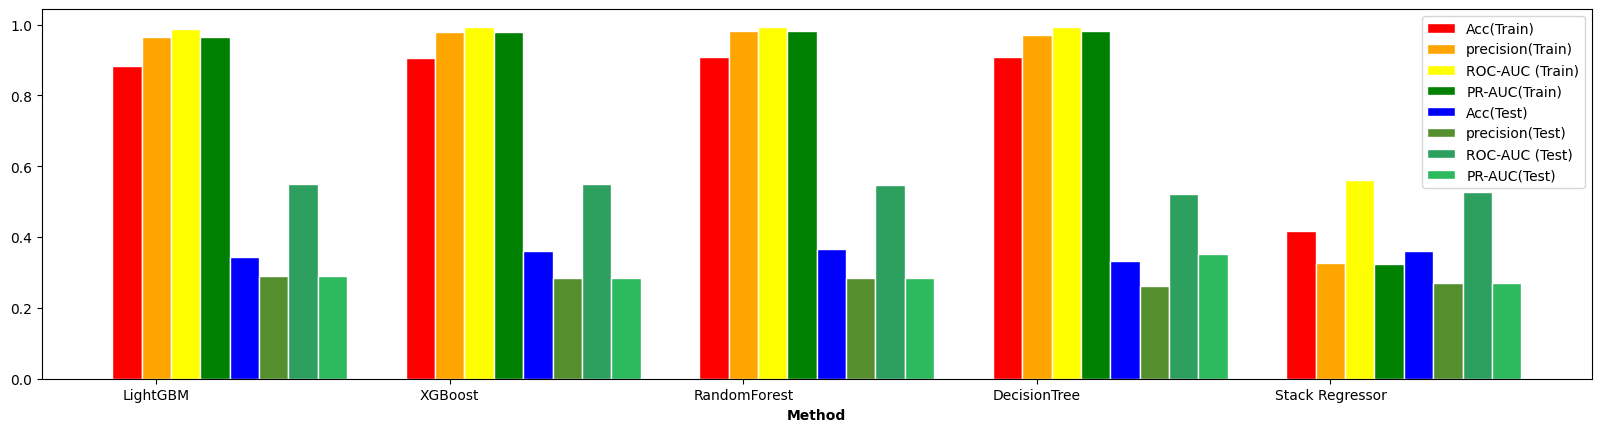

,LightGBM,XGBoost,RandomForest,DecisionTree,Stack Regressor
Acc(Train),0.882353,0.904977,0.907994,0.907994,0.416290
precision(Train),0.966389,0.979381,0.980946,0.971257,0.325618
ROC-AUC (Train),0.988461,0.993377,0.993985,0.994235,0.561879
PR-AUC(Train),0.966611,0.979616,0.981182,0.983120,0.324529
Acc(Test),0.343931,0.360518,0.366047,0.331616,0.361020
precision(Test),0.290028,0.285450,0.284435,0.261475,0.271225
ROC-AUC (Test),0.548757,0.548606,0.547340,0.522013,0.528746
PR-AUC(Test),0.289677,0.285084,0.284215,0.353168,0.270937


In [73]:
barWidth = 0.10

# set heights of bars
names = []
bars = [[],[],[],[],[],[],[],[]]
for name,result in resultList:
    names.append(name)
    bars[0].append(result[0])
    bars[1].append(result[1])
    bars[2].append(result[2])
    bars[3].append(result[3])
    bars[4].append(result[4])
    bars[5].append(result[5])
    bars[6].append(result[6])
    bars[7].append(result[7])

# Set position of bar on X axis
r1 = np.arange(len(bars[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]

# Make the plot
finalPlotLabels = ['Acc(Train)','precision(Train)','ROC-AUC (Train)','PR-AUC(Train)','Acc(Test)','precision(Test)','ROC-AUC (Test)','PR-AUC(Test)']
colours = ['red','orange','yellow','green','blue','#558f2d','#2d9f5e','#2db95e']
r = [r1,r2,r3,r4,r5,r6,r7,r8]
i=0

f = plt.figure()
f.set_figwidth(20)
for finalPlotLabel in finalPlotLabels:
    plt.bar(r[i], bars[i], color=colours[i], width=barWidth, edgecolor='white', label=finalPlotLabel)
    i+=1

# Add xticks on the middle of the group bars
plt.xlabel('Method', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[0]))], names)

# Create legend & Show graphic
plt.legend()
plt.show()
pd.DataFrame(bars,index=finalPlotLabels,columns=names)

In [16]:
totalScore = 0
for i in range(len(y_train.unique())):
    totalScore += roc_auc_score(y_true=y_train, y_score=finalPipe.predict_proba(X_train), multi_class="ovr")

totalScore/len(y_train.unique())

0.55933689870837

AttributeError: This 'StackingClassifier' has no attribute 'predict'

In [15]:
y_train

2113    3
7648    0
1946    3
6865    0
893     0
       ..
360     1
7676    3
3562    3
5154    2
2091    3
Name: Wait Levels, Length: 1989, dtype: int64

In [ ]:
predict_test = rs.predict(X_test)
accuracy_test = accuracy_score(y_test,predict_test)
accuracy_test

In [ ]:
predict_test


In [50]:
finalPipe.fit(X_train, y_train)
predict_prob_test = finalPipe.predict_proba(X_test)
roc_auc_score(y_score=predict_prob_test, y_true=y_test, multi_class="ovr")

0.5582447644109321

In [45]:
finalPipe.fit(X_train, y_train)
predict_prob_test = finalPipe.predict_proba(X_test)
roc_auc_score(y_score=predict_prob_test, y_true=y_test, multi_class="ovr")

0.5284495538273283

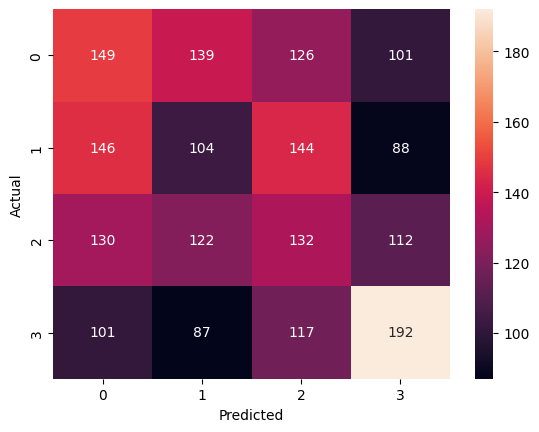

In [51]:
df = pd.DataFrame({'y_Actual':y_test,'y_Predicted':finalPipe.predict(X_test)})
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True,fmt='g')
plt.show()

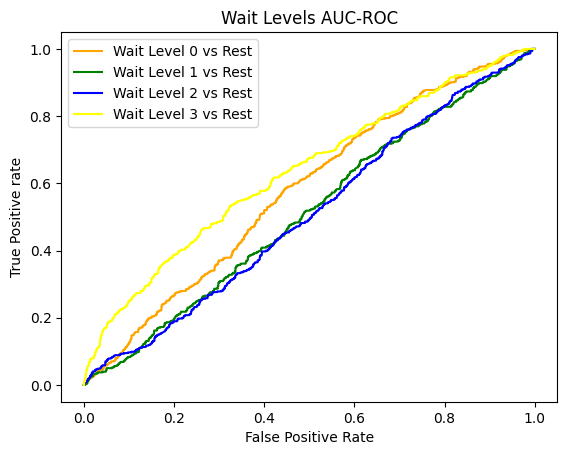

In [59]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
n_class = 4
for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, finalPipe.predict_proba(X_test)[:,i], pos_label=i)

# plotting
plt.plot(fpr[0], tpr[0], linestyle='-',color='orange', label='Wait Level 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='-',color='green', label='Wait Level 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='-',color='blue', label='Wait Level 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='-',color='yellow', label='Wait Level 3 vs Rest')
plt.title('Wait Levels AUC-ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Wait Levels AUC-ROC',dpi=300);

4

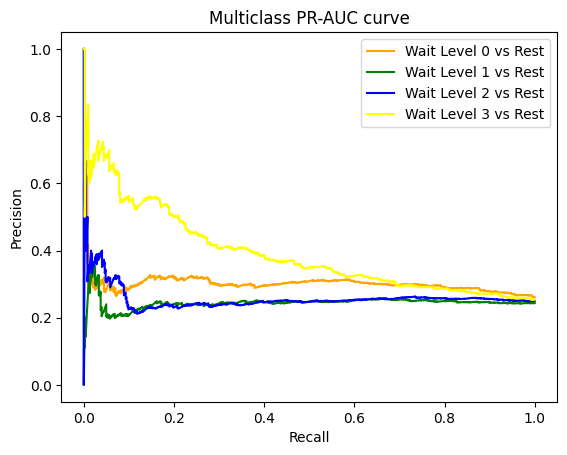

In [58]:
# roc curve for classes
precision = {}
recall = {}
thresh ={}
n_class = 4
for i in range(n_class):
    precision[i], recall[i], thresh[i] = precision_recall_curve(y_test, finalPipe.predict_proba(X_test)[:,i], pos_label=i)

# plotting
plt.plot(recall[0], precision[0], linestyle='-',color='orange', label='Wait Level 0 vs Rest')
plt.plot(recall[1], precision[1], linestyle='-',color='green', label='Wait Level 1 vs Rest')
plt.plot(recall[2], precision[2], linestyle='-',color='blue', label='Wait Level 2 vs Rest')
plt.plot(recall[3], precision[3], linestyle='-',color='yellow', label='Wait Level 3 vs Rest')

plt.title('Multiclass PR-AUC curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.savefig('Wait Levels AUC-ROC',dpi=300);
